In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from math import *
import pickle
import pandas as pd
from tqdm import tqdm
from aero_info import *
from missile_gym import MissileGym
from ipywidgets import interact, interactive, fixed
from matplotlib.pylab import figure, subplot2grid
from interpolation import Interp1d, Interp2d, InterpVec
import ipywidgets

In [2]:
# настройка шрифтов
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# Баллистическое проектирование ЗУР

## 1) Первичный бал проект: решение простейшей задачи траекторного анализа

In [3]:
def ozvb(dict_opts):
    
    """
    Ф-ция решения прямой задачи внешней баллистики (ОЗВБ) ракеты
    argument:  dict_opts {dict}  -- словарь с опциями (начальными данными)
    return:    dict_res  {dict}  -- словарь с результатами решения ОЗВБ
    """
    
    # const:
    g = 9.80665
    
    def func_stop(stop_conditions):
        if stop_conditions == 't0':
            return lambda t: dict_opts['I_10'] * dict_opts['myu_0'] / dict_opts['η_0'] / g - t
        if stop_conditions == 'v_max':
            return lambda v: dict_opts['integr']['value'] - v
        if stop_conditions == 'y_max':
            return lambda y: dict_opts['integr']['value'] - y
        if stop_conditions == 'x_max':
            return lambda x: dict_opts['integr']['value'] - x
        if stop_conditions == 'step_max':
            return lambda i: dict_opts['integr']['value'] - i
        if stop_conditions == 't_max':
            return lambda t: dict_opts['integr']['value'] - t
        
    def ξ_stage(μ, μ_0):
        if μ < μ_0:
            return 1
        else:
            return 0
        
    def system(t, Y, r=dict_opts, Cx=Cx43):
            
        y1 = Y[0] # v
        y2 = Y[1] # θ
        y3 = Y[2] # x
        y4 = Y[3] # y
        y5 = Y[4] # μ 
        
        M = y1 / table_atm(y4, 4)
        
        a1_1 = g * r['η_0'] / (1 - y5) * ξ_stage(y5, r['myu_0'])
        a1_2 = g * r['i'] * Cx(M) * table_atm(y4, 3) * y1**2 / (2 * r['q_M'] * (1 - y5))
        a1_3 = g * np.sin(y2)
        
        # dv/dt
        f1 = a1_1 - a1_2 - a1_3
        # dθ/dt
        f2 = 0
        # dx/dt
        f3 = y1 * np.cos(y2)
        # dy/dt
        f4 = y1 * np.sin(y2)
        # dμ/dt
        f5 = g * (r['η_0'] / r['I_10']) * ξ_stage(y5, r['myu_0'])
        
        return np.array([f1, f2, f3, f4, f5])
   
    def RK4(F, Y0, stop_conditions=dict_opts['integr']['stop_conditions'],
            func_end=func_stop(dict_opts['integr']['stop_conditions']), 
            dt=dict_opts['integr']['dt'], y=dict_opts['init_conditions']['y'],
            t0=0, max_time=300): 
        
        ti = t0 
        Yi = Y0
        res = {
        'y1': [Y0[0]],
        'y2': [Y0[1]],
        'y3': [Y0[2]],
        'y4': [Y0[3]],
        'y5': [Y0[4]],
        'Mach': [Y0[0]/table_atm(Y0[3],4)],
        't': [t0],
        'stop_reason': ''        
        }

        def foo_init_stop(stop_conditions, fint, *args):
            if stop_conditions == 't0':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            elif stop_conditions == 'v_max':
                if fint == 1:
                    return args[0][0]
                if fint == 0:
                    return Y0[0]
            elif stop_conditions == 'y_max':
                if fint == 1:
                    return args[0][3]
                if fint==0:
                    return Y0[3]
            elif stop_conditions == 'x_max':
                if fint == 1:
                    return args[0][2]
                if fint == 0:
                    return Y0[2]
            elif stop_conditions == 't_max':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            else:
                print('unknown condition')
        
        flag = True
        var = foo_init_stop(stop_conditions, 0, Yi, ti)
        
        while func_end(var) > 0 and ti < max_time and Yi[3] < 8e4 and flag == True:
            
            k1 = F(ti, Yi)
            k2 = F(ti + dt / 2, Yi + k1 * dt / 2)
            k3 = F(ti + dt / 2, Yi + k2 * dt / 2)
            k4 = F(ti + dt, Yi + k3 * dt)
            Yi += dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
            
            ti += dt
            if Yi[3] <= 0:
                flag = False
            
            var = foo_init_stop(stop_conditions, 1, Yi, ti)
            
            res['y1'].append(Yi[0])
            res['y2'].append(Yi[1])
            res['y3'].append(Yi[2])
            res['y4'].append(Yi[3])
            res['y5'].append(Yi[4])
            res['Mach'].append(Yi[0]/table_atm(Yi[3],4))
            res['t'].append(ti)
            
        if func_end(var) < 0:
            stop_reason = dict_opts['integr']['stop_conditions']
        elif ti >= max_time:
            stop_reason = 'max_time'
        elif Yi[3] <= 0:
            stop_reason = f'missile arrived (x = {Yi[2]}; y = 0)'
        elif Yi[3] >= 8e4:
            stop_reason = 'y_max_atmo'
        else:
            stop_reason = 'unknown reason'
        res['stop_reason'] = stop_reason
        print(f'stop reason: {stop_reason};\nflight time: {ti} с.;')
        
        return res
    
    init = [dict_opts['init_conditions']['v'], np.radians(dict_opts['init_conditions']['thetta']),
            dict_opts['init_conditions']['x'], dict_opts['init_conditions']['y'], 0]
    
    fl_start = timeit.default_timer()
    res = RK4(system, init)
    fl_end   = timeit.default_timer() - fl_start 
    print(f'execution time: {fl_end} с.')
    
    dict_res = {
        'v': np.array(res['y1']),
        'thetta': np.array(res['y2']),
        'x':  np.array(res['y3']),
        'y': np.array(res['y4']),
        'myu':  np.array(res['y5']),
        't':  np.array(res['t']),
        'Mach': np.array(res['Mach']),
        'stop_reason': res['stop_reason'],
        'execution_time': fl_end
    }

    return dict_res

In [4]:
thetta_opt = np.arctan(7e3/15e3) * 180 / np.pi
thetta_opt

25.016893478100023

In [5]:
opts = {
    'init_conditions': {'l_pusk': 3,
                        'x': 0,
                        'y': 30,
                        'v': 30,
                        'thetta': thetta_opt},
    'η_0': None,
    'I_10': None,
    'q_M': None,
    'i': 1.2,
    'integr': {'stop_conditions': 'x_max',
               'value': 15e3,
               'dt': 1e-2}
} 

In [6]:
mass_η_0 = np.arange(12, 15.5, 0.5)
mass_q_M = np.arange(35e3, 40e3, 500)
V_max = 1100
opts['I_10'] = 2550
RESULT = {}
OPTS = {}
n = 0
for i in tqdm(mass_η_0):
    for k in mass_q_M:
        myu_0 = 1 - np.exp(-((V_max - opts['init_conditions']['v']) / (0.92 * opts['I_10'])))
        opts['myu_0'] = myu_0
        opts['η_0'] = i
        opts['q_M'] = k
        res = ozvb(opts)
        OPTS[n] = (myu_0, i, k)
        RESULT[n] = (max(res['v']), res['v'][-1], res['y'][-1], res['x'][-1], res['myu'][-1], res['t'][-1], res['stop_reason'])
        n += 1

  0%|                                                                                            | 0/7 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [6]:
mass_η_0 = np.arange(12, 15.5, 0.5)
mass_I_10 = np.arange(2400, 2650, 50)
mass_q_M = np.arange(35e3, 40e3, 500)
mass_η_0, mass_I_10, mass_q_M

(array([12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ]),
 array([2400, 2450, 2500, 2550, 2600]),
 array([35000., 35500., 36000., 36500., 37000., 37500., 38000., 38500.,
        39000., 39500.]))

In [ ]:
V_max = 1100
RESULT = {}
OPTS = {}
n = 0
for i in tqdm(mass_η_0):
    for j in mass_I_10:
        for k in mass_q_M:
            myu_0 = 1 - np.exp(-((V_max - opts['init_conditions']['v']) / (0.92 * j)))
            opts['myu_0'] = myu_0
            opts['η_0'] = i
            opts['I_10'] = j
            opts['q_M'] = k
            res = ozvb(opts)
            OPTS[n] = (myu_0, i, j, k)
            RESULT[n] = (max(res['v']), res['v'][-1], res['y'][-1], res['x'][-1], res['myu'][-1], res['t'][-1], res['stop_reason'])
            n += 1

In [7]:
with open('bp_opts.bin', 'wb') as f:
    pickle.dump(OPTS, f)
with open('bp_resilt.bin', 'wb') as f:
    pickle.dump(RESULT, f)

In [10]:
with open('bp_opts.bin', 'rb') as f:
    OPTS = pickle.load(f)
with open('bp_resilt.bin', 'rb') as f:
    RESULT = pickle.load(f)

In [11]:
d = 0.240
S_mid = np.pi * d**2 / 4
mass_m0 = {etta: [] for etta in mass_η_0}
mass_v0 = {etta: [] for etta in mass_η_0}
mass_m0_odz = []
mass_v0_odz = []
keys = []

for key in RESULT:
    m_0 = OPTS[key][-1] * S_mid / 9.80665
    v_0 = RESULT[key][0]
    mass_m0[OPTS[key][1]].append(m_0)
    mass_v0[OPTS[key][1]].append(v_0)
    if RESULT[key][0] > 1000:
        m_0 = OPTS[key][-1] * S_mid / 9.80665
        v_0 = RESULT[key][0]
        mass_m0_odz.append(m_0)
        mass_v0_odz.append(v_0)
        keys.append(key)

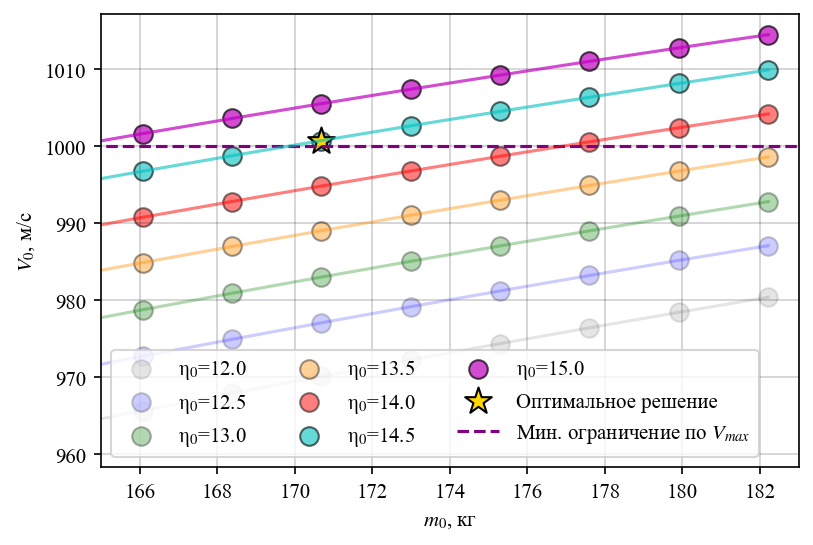

In [12]:
plt.figure(dpi=150)
colors = {key: i for key, i in zip(mass_η_0, ['k', 'b', 'g', 'darkorange', 'r', 'c', 'm', 'y'])}
alpha = 0.1

for key in mass_m0:
    plt.scatter(mass_m0[key], mass_v0[key], c=colors[key], edgecolors='k', alpha=alpha, s=80, marker='o', label=f'η$_0$={key}')
    plt.plot(mass_m0[key], mass_v0[key], alpha=alpha, c=colors[key])
    alpha += 0.1

plt.scatter(mass_m0_odz[3], mass_v0_odz[3], edgecolors='k', c='gold', s=180, marker='*', label='Оптимальное решение')

plt.hlines(1000, 160, 185, linestyle='--', colors='purple', label='Мин. ограничение по $V_{max}$')
plt.xlim(165, 183)
plt.xlabel('$m_0$, кг'), plt.ylabel('$V_0$, м/с') 
plt.grid(True, linewidth=0.15, color='k')
plt.legend(ncol=3)
plt.show()

In [13]:
opts['myu_0'], opts['η_0'], opts['q_M'], opts['I_10'] = *OPTS[keys[3]], 2550
res = ozvb(opts)

stop reason: x_max;
flight time: 28.760000000001696 с.;
execution time: 40.23134610000011 с.


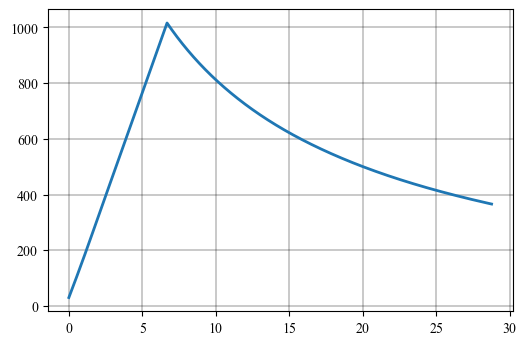

In [14]:
plt.figure(dpi=100)
plt.plot(res['t'], res['v'], lw=2, ls='-')
plt.grid(True, linewidth=0.3, color='k')
plt.show()

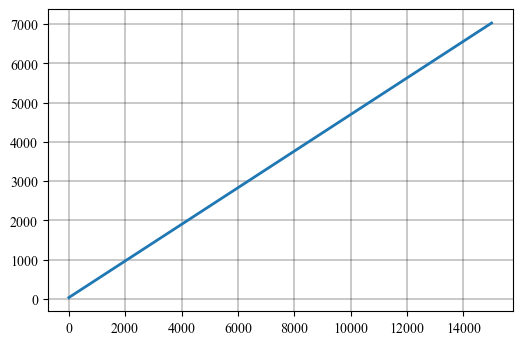

In [15]:
plt.figure(dpi=100)
plt.plot(res['x'], res['y'], lw=2, ls='-')
plt.grid(True, linewidth=0.3, color='k')
plt.show()

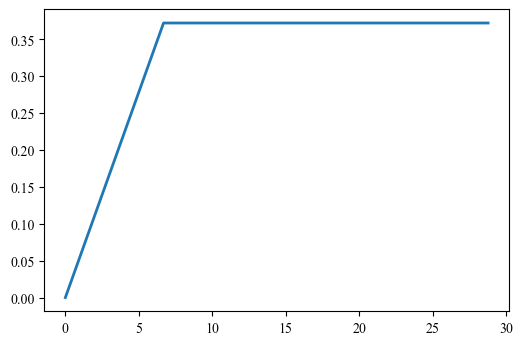

In [16]:
plt.figure(dpi=100)
plt.plot(res['t'], res['myu'], lw=2, ls='-')
plt.show()

In [17]:
g = 9.80665
d = 0.240
gamma = 1250 
# ---------------------------------------
t_marsh = res['t'][np.argmax(res['myu'])]
myu_marsh = max(res['myu'])
vel_mid = np.average(res['v'])
vel_max = max(res['v'])
m_0 = opts['q_M'] * np.pi * d**2 / 4 / g
P_0 =  opts['η_0'] * m_0 * g
w_marsh = m_0 * myu_marsh
I_p = P_0 * t_marsh
l_korp = m_0 / (np.pi * d**2 / 4 * gamma)
lambd_korp = l_korp / d
print(f' m0 = {m_0};\n w = {w_marsh};\n myu = {myu_marsh};\n P = {P_0};\n t = {t_marsh};\n I_p = {I_p};\n l_p = {l_korp};\n lambd_korp = {lambd_korp};\n Vmax = {vel_max};\n Vcp = {vel_mid}')

 m0 = 170.6842362919694;
 w = 63.53209559432441;
 myu = 0.3722200536764716;
 P = 24270.688204573304;
 t = 6.679999999999902;
 I_p = 162128.19720654728;
 l_p = 3.0183599904146674;
 lambd_korp = 12.576499960061115;
 Vmax = 1015.9548902555453;
 Vcp = 575.4235444152247


In [123]:
G = 64.4 / 6.7
Pud = 24300 / G
Pud

2528.105590062112

## 2) Траекторный анализ более подробной математической модели

In [1]:
from missile import Missile2D
from missile_gym import MissileGym
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np

from ipywidgets import interact, interactive, fixed
import ipywidgets
from matplotlib.pylab import figure, subplot2grid

In [2]:
missile_opts = {
    'd': 0.240,
    'm_0': 170.7,
    't_marsh': 6.7,
    'w_marsh': 63.5,
    'P_marsh': 24.3e3,
    'r_kill': 50,
    'alpha_max': 12,
    'xi': 0.5,
    'am': 5,
    'dny': 1,
    'init_conditions': {'V_0': 25, 'pos_0': (0, 25)}
}

In [3]:
trg_pos = (25e3, 7e3)
trg_vel = (-350, 0)

In [4]:
sim_scenario = MissileGym.make_simple_scenario(missile_opts, trg_pos, trg_vel, t_max=25)
%time res_hit = MissileGym.launch(sim_scenario) # aero=False, record=True, desc=True

Meeting point: False
info = target destroyed
Wall time: 44.3 s


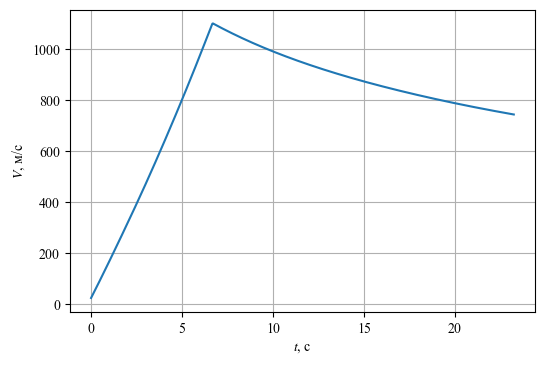

(787.847738994198, 1099.655963929262, 23.22000000000083)

In [13]:
plt.figure(dpi=100)
plt.plot(res_hit['t'], res_hit['missile']['v'])
plt.ylabel('$V$, м/с')
plt.xlabel('$t$, с')
plt.grid()
plt.show()
np.mean(res_hit['missile']['v']), max(res_hit['missile']['v']), res_hit['t'][-1]

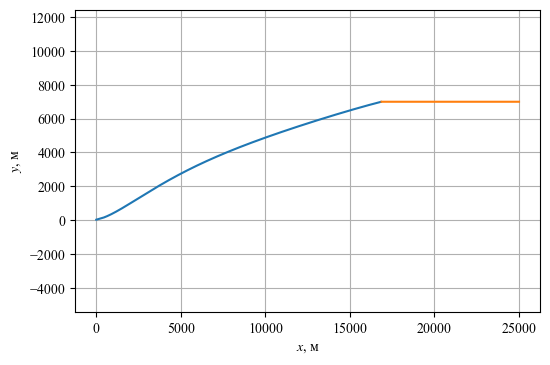

In [14]:
%matplotlib inline
plt.figure(dpi=100)
plt.plot(res_hit['missile']['x'], res_hit['missile']['y'])
plt.plot(res_hit['target']['x'], res_hit['target']['y'])
plt.grid()
plt.ylabel('$y$, м')
plt.xlabel('$x$, м')
plt.axis('equal')
plt.show()

In [15]:
@interact(i=ipywidgets.IntSlider(description='tau', max=len(res_hit['t'])-1, step=1, value=len(res_hit['t'])-1))
def draw_gym_hit(i):
    
    plt.figure(figsize=(16,12))
    
    ax01 = subplot2grid((8, 4), (0, 0), colspan=4, rowspan=4)
    ax02 = subplot2grid((8, 4), (4, 0), colspan=2, rowspan=2)
    ax03 = subplot2grid((8, 4), (6, 0), colspan=2, rowspan=2,sharex=ax02)
    ax04 = subplot2grid((8, 4), (4, 2), colspan=2, rowspan=2,sharex=ax02)
    ax05 = subplot2grid((8, 4), (6, 2), colspan=2, rowspan=2,sharex=ax02)
    
    ax01.plot(res_hit['missile']['x'][:i], res_hit['missile']['y'][:i], lw=3, ls=':', color='k', label='траектория ракеты')
    ax01.plot(res_hit['target']['x'][:i], res_hit['target']['y'][:i], lw=3, ls=':', color='red', label='траектория цели')
    ax01.tick_params(labelsize=12, pad = 0)
    ax01.legend(loc='best', fontsize=14)
    ax01.grid(True)
    
    ax02.plot(res_hit['t'][:i], res_hit['missile']['v'][:i], label='$V_р$', c='k')
    ax02.plot(res_hit['t'][:i], res_hit['target']['v'][:i], label='$V_ц$', c='red')
    ax02.tick_params(left=True, labelleft=True,labelbottom=False, bottom=False, right=False, labelright=False, labelsize=12)
    ax02.legend(fontsize=14)
    ax02.grid(True)
    
    ax03.plot(res_hit['t'][:i], res_hit['missile']['ny'][:i], label=r'$n_y$ ракеты', c='k')
    ax03.plot(res_hit['t'][:i], res_hit['missile']['nx'][:i], label=r'$n_x$ ракеты', c='k', ls='--')
#     ax03.plot(res_hit['t'][:i], res_hit['target']['ny'][:i], label=r'$n_y$ цели', c='red')
#     ax03.plot(res_hit['t'][:i], res_hit['target']['nx'][:i], label=r'$n_x$ цели', c='red', ls='--')
    ax03.legend(loc='best', ncol=2, fontsize=14)
    ax03.tick_params(left=True, labelleft=True, right=False, labelright=False, labelsize=12)
    ax03.grid(True)
    
    ax04.plot(res_hit['t'][:i], res_hit['missile']['alpha'][:i], label=r'$\alpha$', color='k')
    ax04.plot(res_hit['t'][:i], res_hit['alpha_targeting'][:i], label=r'$\alpha_{пот}$', color='darkorange', ls='-')
    ax04.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, right=True, labelright=True, labelsize=12)
    ax04.legend(fontsize=14)
    ax04.grid(True)
       
    ax05.plot(res_hit['t'][:i], res_hit['missile']['Q'][:i], color='k', label='Q')
    ax05.tick_params(left=False, labelleft=False, right=True, labelright=True, labelsize=12)
    ax05.legend(fontsize=14)
    ax05.grid(True)
    
    plt.savefig('Баллистика.png', dpi=400, bbox_inches='tight')
    
    plt.show()

interactive(children=(IntSlider(value=2322, description='tau', max=2322), Output()), _dom_classes=('widget-int…

## 3) Построение зоны поражения и пуска

In [15]:
trg_vel = (-1e-5, 0)
xs = np.linspace(-20e3, 20e3, 51)
ys = np.linspace(100, 7e3, 21)

In [16]:
def foo_gym_hit(missile_opts, trg_pos, trg_vel, t_max=22, desc=False):
    sim_scenario = MissileGym.make_simple_scenario(missile_opts, trg_pos, trg_vel, t_max=25, desc=False)
    res = MissileGym.launch(sim_scenario)
    return {'t': res['t'][-1],
            'info': res['info'],
            'missile': {
                'x': res['missile']['x'][-1],
                'y': res['missile']['y'][-1],
                'ny': max(res['missile']['ny']),
                'nx': max(res['missile']['nx'])
                       },
            'target': {
                'x': res['target']['x'][-1],
                'y': res['target']['y'][-1],
                'x0': res['target']['x'][0],
                'y0': res['target']['y'][0],
                'ny': max(res['target']['ny']),
                'nx': max(res['target']['nx'])
                       }
           }

In [9]:
res_gym = []
for x in tqdm(xs):
    for y in ys:
        res_gym.append(foo_gym_hit(missile_opts, (x, y), trg_vel))

  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly


  2%|█▌                                                                              | 1/51 [09:52<8:13:49, 592.58s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly


  4%|███▏                                                                            | 2/51 [19:50<8:06:36, 595.85s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly


  6%|████▋                                                                           | 3/51 [30:26<8:11:23, 614.24s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


  8%|██████▎                                                                         | 4/51 [40:47<8:03:08, 616.77s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 10%|███████▊                                                                        | 5/51 [50:21<7:40:56, 601.22s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 12%|█████████▍                                                                      | 6/51 [59:27<7:16:57, 582.62s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 14%|██████████▋                                                                   | 7/51 [1:08:38<6:59:37, 572.21s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 16%|████████████▏                                                                 | 8/51 [1:17:52<6:45:58, 566.49s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 18%|█████████████▊                                                                | 9/51 [1:26:00<6:19:23, 541.99s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 20%|███████████████                                                              | 10/51 [1:33:39<5:52:42, 516.15s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 22%|████████████████▌                                                            | 11/51 [1:40:40<5:24:47, 487.18s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 24%|██████████████████                                                           | 12/51 [1:47:18<4:59:04, 460.13s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 25%|███████████████████▋                                                         | 13/51 [1:53:50<4:38:18, 439.44s/it]

info = missile fell
info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 27%|█████████████████████▏                                                       | 14/51 [2:00:03<4:18:38, 419.43s/it]

info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 29%|██████████████████████▋                                                      | 15/51 [2:06:09<4:01:56, 403.25s/it]

info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 31%|████████████████████████▏                                                    | 16/51 [2:11:56<3:45:25, 386.43s/it]

info = missile fell
info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 33%|█████████████████████████▋                                                   | 17/51 [2:17:27<3:29:25, 369.58s/it]

info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 35%|███████████████████████████▏                                                 | 18/51 [2:22:49<3:15:22, 355.23s/it]

info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 37%|████████████████████████████▋                                                | 19/51 [2:27:54<3:01:24, 340.14s/it]

info = missile fell
info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 39%|██████████████████████████████▏                                              | 20/51 [2:32:41<2:47:33, 324.31s/it]

info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 41%|███████████████████████████████▋                                             | 21/51 [2:37:24<2:35:54, 311.81s/it]

info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 43%|█████████████████████████████████▏                                           | 22/51 [2:42:00<2:25:34, 301.19s/it]

info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 45%|██████████████████████████████████▋                                          | 23/51 [2:46:52<2:19:11, 298.26s/it]

info = missile fell
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 47%|████████████████████████████████████▏                                        | 24/51 [2:51:18<2:09:52, 288.63s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 49%|█████████████████████████████████████▋                                       | 25/51 [2:55:26<1:59:46, 276.39s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 51%|███████████████████████████████████████▎                                     | 26/51 [2:59:23<1:50:13, 264.55s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 53%|████████████████████████████████████████▊                                    | 27/51 [3:03:32<1:44:01, 260.05s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 55%|██████████████████████████████████████████▎                                  | 28/51 [3:08:13<1:42:05, 266.31s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 57%|███████████████████████████████████████████▊                                 | 29/51 [3:12:53<1:39:07, 270.32s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 59%|█████████████████████████████████████████████▎                               | 30/51 [3:17:45<1:36:52, 276.79s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 61%|██████████████████████████████████████████████▊                              | 31/51 [3:23:07<1:36:47, 290.37s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 63%|████████████████████████████████████████████████▎                            | 32/51 [3:28:47<1:36:40, 305.31s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 65%|█████████████████████████████████████████████████▊                           | 33/51 [3:34:50<1:36:47, 322.61s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 67%|███████████████████████████████████████████████████▎                         | 34/51 [3:41:16<1:36:47, 341.62s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 69%|████████████████████████████████████████████████████▊                        | 35/51 [3:48:32<1:38:38, 369.88s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 71%|██████████████████████████████████████████████████████▎                      | 36/51 [3:55:41<1:36:55, 387.70s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 73%|███████████████████████████████████████████████████████▊                     | 37/51 [4:03:26<1:35:53, 410.97s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 75%|█████████████████████████████████████████████████████████▎                   | 38/51 [4:12:11<1:36:26, 445.13s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 76%|██████████████████████████████████████████████████████████▉                  | 39/51 [4:21:25<1:35:32, 477.67s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 78%|████████████████████████████████████████████████████████████▍                | 40/51 [4:31:11<1:33:34, 510.40s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 80%|█████████████████████████████████████████████████████████████▉               | 41/51 [4:41:40<1:30:58, 545.85s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 82%|███████████████████████████████████████████████████████████████▍             | 42/51 [4:52:34<1:26:44, 578.24s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 84%|████████████████████████████████████████████████████████████████▉            | 43/51 [5:04:18<1:22:07, 615.95s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 86%|██████████████████████████████████████████████████████████████████▍          | 44/51 [5:16:16<1:15:25, 646.55s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 88%|███████████████████████████████████████████████████████████████████▉         | 45/51 [5:29:20<1:08:46, 687.80s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 90%|█████████████████████████████████████████████████████████████████████▍       | 46/51 [5:43:05<1:00:44, 728.91s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 92%|████████████████████████████████████████████████████████████████████████▊      | 47/51 [5:56:36<50:14, 753.55s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed


 94%|██████████████████████████████████████████████████████████████████████████▎    | 48/51 [6:11:01<39:21, 787.00s/it]

info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = a long time to fly
info = a long time to fly


 96%|███████████████████████████████████████████████████████████████████████████▉   | 49/51 [6:26:06<27:24, 822.43s/it]

info = a long time to fly
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = target destroyed
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 50/51 [6:41:30<14:12, 852.99s/it]

info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly
info = a long time to fly


100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [6:56:59<00:00, 490.58s/it]


In [10]:
with open('saves/zone_affected.bin', 'wb') as f:
    pickle.dump(res_gym, f)

In [17]:
with open('saves/zone_affected.bin', 'rb') as f:
    res_gym = pickle.load(f)

In [18]:
zone_ny = []
zone_xs = []
zone_ys = []
zone_xs0 = []
zone_ys0 = []
zone_ts = []

for i in range(len(res_gym)):
    zone_ny.append(np.absolute(res_gym[i]['missile']['ny']))
    zone_xs.append(res_gym[i]['missile']['x'])
    zone_ys.append(res_gym[i]['missile']['y'])
    zone_xs0.append(res_gym[i]['target']['x0'])
    zone_ys0.append(res_gym[i]['target']['y0'])
    zone_ts.append(res_gym[i]['t'])
res_dict = {'x': zone_xs, 'y': zone_ys, 'x0': zone_xs0, 'y0': zone_ys0, 't': zone_ts, 'ny': zone_ny}

In [13]:
with open('saves/zone_destroy.bin', 'wb') as f:
    pickle.dump(res_dict, f)

In [93]:
with open('saves/zone_destroy.bin', 'rb') as f:
    zone = pickle.load(f)

In [94]:
ny_r = 25 # располагаемая перегрузка
zone_xs = []
zone_ys = []
zone_ts = []
zone_pusk_xs = []
zone_pusk_ys = []
for i in range(len(zone['ny'])):
    if zone['ny'][i] <= ny_r and (np.sqrt(zone['x'][i]**2 + zone['y'][i]**2) >= 3000):
        zone_xs.append(zone['x'][i])
        zone_ys.append(zone['y'][i])
        zone_ts.append(zone['t'][i])
        zone_pusk_xs.append(zone['x0'][i] + zone['t'][i]*500)
        zone_pusk_ys.append(zone['y0'][i])

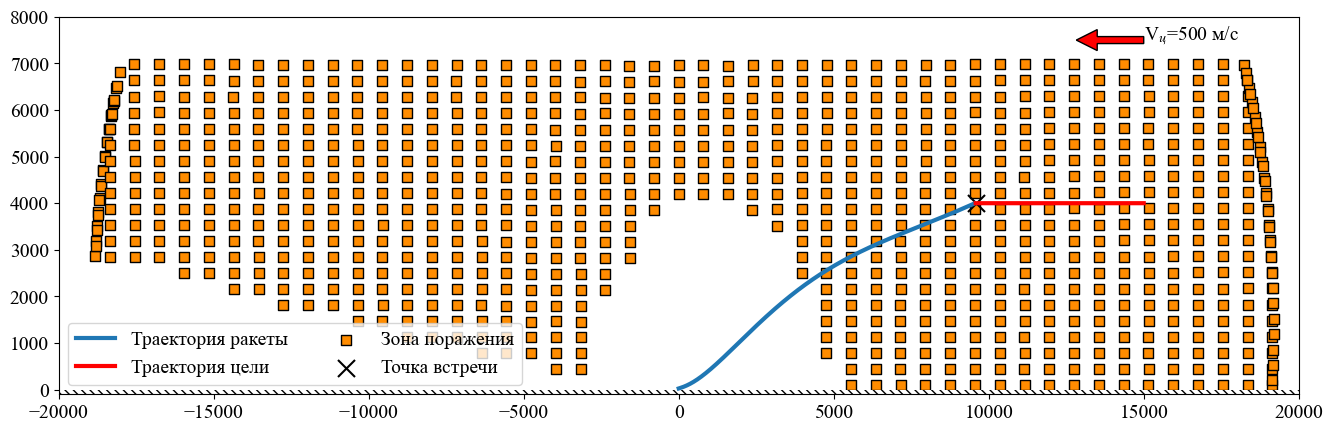

In [82]:
plt.figure(figsize=(16, 5), dpi=100)
plt.scatter(zone_xs, zone_ys, s=50, marker='s', c='darkorange', edgecolors='k', label='Зона поражения')
plt.plot(res_hit['missile']['x'], res_hit['missile']['y'], lw=3, label='Траектория ракеты')
plt.plot(res_hit['target']['x'], res_hit['target']['y'], lw=3, c='r', label='Траектория цели')
plt.scatter(res_hit['target']['x'][-1], res_hit['target']['y'][-1], s=150, marker='x', c='k', label='Точка встречи')
plt.fill_between([-20e3, 20e3], [0,0], [-1000, -1000], facecolor='white', hatch='\\\\\\\\', linewidth=0.5)
plt.arrow(15e3, 7.5e3, -1500, 0, width=150, facecolor='r', edgecolor='k')
plt.text(15e3, 7.5e3, 'V$_ц$=500 м/с', fontsize=14)
plt.legend(fontsize=14, ncol=2)
plt.ylim(-100, 8000)
plt.xlim(-20e3, 20e3)
plt.tick_params(labelsize=14)
plt.savefig('Зона поражения.png', dpi=300, bbox_inches='tight')
plt.show()

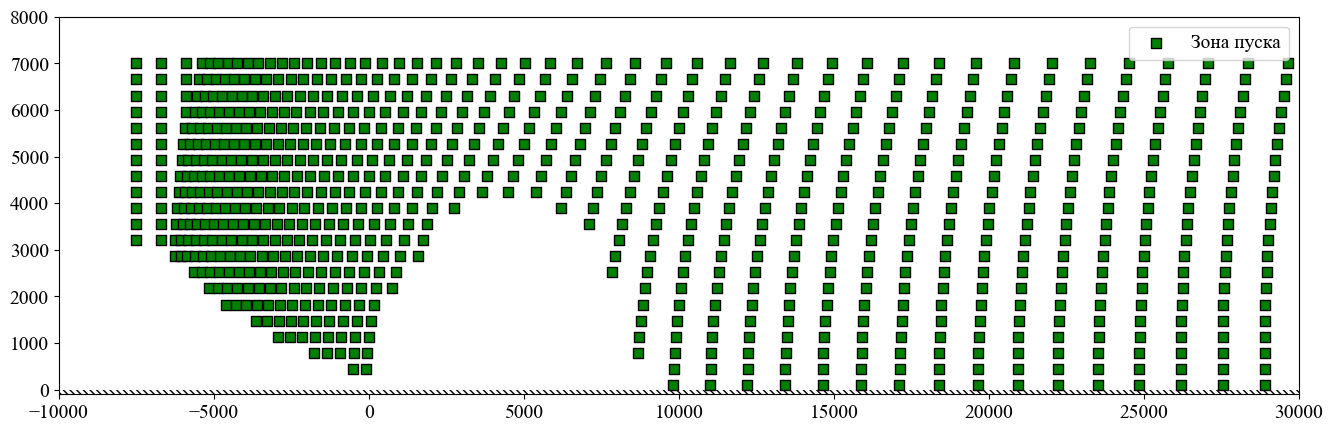

In [101]:
plt.figure(figsize=(16, 5), dpi=100)
plt.fill_between([-10e3, 30e3], [0, 0], [-1000, -1000], facecolor='white', hatch='\\\\\\\\\\', linewidth=0.5)
plt.scatter(zone_pusk_xs, zone_pusk_ys, marker='s', c='green', edgecolors='k', s=50, label='Зона пуска')
plt.legend(fontsize=14)
plt.ylim(-100, 8000)
plt.xlim(-10e3, 30e3)
plt.tick_params(labelsize=14)
plt.savefig('Зона пуска.png', dpi=300, bbox_inches='tight')
plt.show()

## 2) Определение АД коэффициентов для более подробной мат модели

### 2.1. Центровочный расчет ракеты

In [90]:
# длины отсеков
L1, L2, L3, L4, L5, L6 = 0.339, 0.355, 0.328, 0.428, 1.35, 0.2
L_korp = L1+L2+L3+L4+L5+L6
L_korp

3.0

In [91]:
# из расчета РДТТ
w_marsh = 64.4

In [92]:
# массы отсеков
m1 = 7
m2 = 19
m3 = 17
m4 = 30.2
m5 = 80
m6 = 17.5
m1+m2+m3+m4+m5+m6

170.7

In [85]:
# центры масс отсеков
x_ct1 = 0.269
x_ct2 = 0.529
x_ct3 = 0.841
x_ct4 = 1.140
x_ct5 = 2.244
x_ct6 = 2.720

In [86]:
# центры масс ракеты в характерных точках
x_ct_0     = (m1 * x_ct1 + m2 * x_ct2 + m3 * x_ct3 + m4 * x_ct4 + m5 * x_ct5             + m6 * x_ct6) / (m1 + m2 + m3 + m4 + m5 + m6)
x_ct_marsh = (m1 * x_ct1 + m2 * x_ct2 + m3 * x_ct3 + m4 * x_ct4 + (m5 - w_marsh) * x_ct5 + m6 * x_ct6) / (m1 + m2 + m3 + m4 +( m5 - w_marsh) + m6)
x_ct_0, x_ct_marsh

(1.685875805506737, 1.3477460018814675)

In [87]:
# разбежка центра масс
razbezhka = (x_ct_0 - x_ct_marsh) / L_korp * 100
razbezhka

11.270993454175652

In [88]:
I1 = m1 * (x_ct1 - x_ct_0) ** 2
I2 = m2 * (x_ct2 - x_ct_0) ** 2
I3 = m3 * (x_ct3 - x_ct_0) ** 2
I4 = m4 * (x_ct4 - x_ct_0) ** 2
I5 = m5 * (x_ct5 - x_ct_0) ** 2
I6 = m6 * (x_ct6 - x_ct_0) ** 2
I0 = I1 + I2 + I3 + I4 + I5 + I6
I0

104.25042956707676

In [89]:
I1пуст = m1 * (x_ct1 - x_ct_marsh) ** 2
I2пуст = m2 * (x_ct2 - x_ct_marsh) ** 2
I3пуст = m3 * (x_ct3 - x_ct_marsh) ** 2
I4пуст = m4 * (x_ct4 - x_ct_marsh) ** 2
I5пуст = (m5 - w_marsh) * (x_ct5 - x_ct_marsh) ** 2
I6пуст = m6 * (x_ct6 - x_ct_marsh) ** 2
Iпуст = I1пуст + I2пуст + I3пуст + I4пуст + I5пуст + I6пуст
Iпуст

72.03619454205082

In [93]:
x_ct1 - x_ct_0, x_ct2 - x_ct_0, x_ct3 - x_ct_0, x_ct4 - x_ct_0, x_ct5 - x_ct_0, x_ct6 - x_ct_0

(-1.416875805506737,
 -1.1568758055067372,
 -0.8448758055067371,
 -0.5458758055067372,
 0.5581241944932631,
 1.034124194493263)

In [94]:
x_ct1 - x_ct_marsh, x_ct2 - x_ct_marsh, x_ct3 - x_ct_marsh, x_ct4 - x_ct_marsh, x_ct5 - x_ct_marsh, x_ct6 - x_ct_marsh

(-1.0787460018814676,
 -0.8187460018814675,
 -0.5067460018814676,
 -0.20774600188146763,
 0.8962539981185327,
 1.3722539981185327)

### 2.2. Определение АД характеристик на траектории полета полученного профиля скорости

In [1]:
from missile import Missile2D
from missile_gym import MissileGym
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np

from ipywidgets import interact, interactive, fixed
import ipywidgets
from matplotlib.pylab import figure, subplot2grid

In [2]:
missile_opts = {
    'd': 0.240,
    'm_0': 170.7,
    't_marsh': 6.7,
    'w_marsh': 63.5,
    'P_marsh': 24.3e3,
    'r_kill': 50,
    'alpha_max': 12,
    'xi': 0.5,
    'am': 5,
    'dny': 1,
    'init_conditions': {'V_0': 25, 'pos_0': (0, 25)}
}

In [3]:
trg_pos = (25e3, 7e3)
trg_vel = (-350, 0)

In [4]:
sim_scenario = MissileGym.make_simple_scenario(missile_opts, trg_pos, trg_vel, tau=0.1, t_max=25)
%time res_hit = MissileGym.launch(sim_scenario) # aero=False, record=True, desc=True

Meeting point: False
info = target destroyed
Wall time: 24.1 s


In [5]:
from aero import Aerodynamic

In [43]:
geom_opts = {
    'd': 0.24,
    'a': 0.2,
    't_marsh': 6.7,
    'x_ct_0': 1.686,
    'x_ct_marsh': 1.348,
    'L_korp': 3.0,
    'L_nos': 0.69,
    'L_cil': 2.104,
    'L_korm': 0.206,
    'betta_kon': 18,
    'd_korm': 0.120,
    'class_korp': 8, #
    'S_oper': 0.125,
    'c_oper': 0.006,
    'L_oper': 0.535,
    'b_0_oper': 0.326,
    'x_b_oper': 0.3624,
    'khi_pk_oper': 34.5,
    'khi_rul': 0,
    'class_oper': 8,
    'S_kr': 0.304,
    'c_kr': 0.008,
    'L_kr': 0.62,
    'b_0_kr': 0.76,
    'x_b_kr': 2.444,
    'khi_pk_kr': 60,  
    'class_kr': 8
}

In [44]:
AERO_MODEL = Aerodynamic.get_aero_models(geom_opts)
AERO_RES = AERO_MODEL.get_aero_const(res_hit)

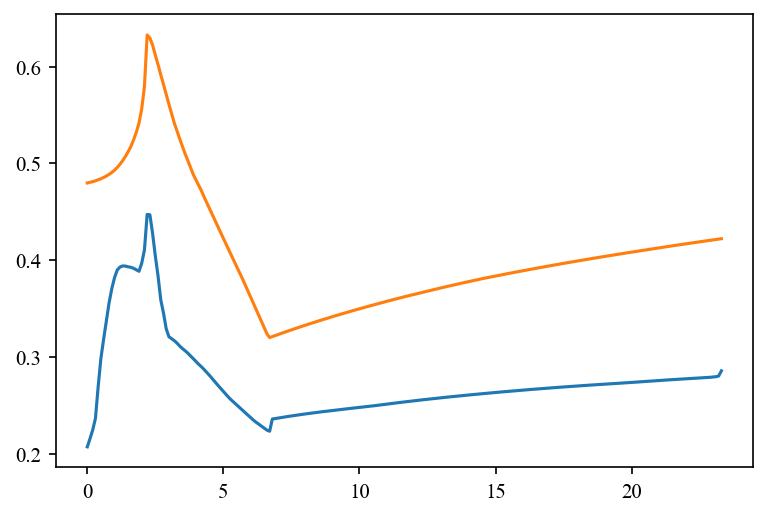

In [64]:
plt.figure(dpi=150)
plt.plot([i['t'] for i in AERO_RES], [i['Cx'] for i in AERO_RES])
plt.plot([i['t'] for i in AERO_RES], [i['Cy_alpha'] for i in AERO_RES])

In [162]:
mass_S_oper, count_S_oper = np.arange(0.5, 2.5, 0.01), 0.01
mass_xb_oper, count_xb_oper = np.linspace(5.5, 8.5, 100, retstep=True)
mass_L_oper, count_L_oper = np.linspace(1.0, 2.0, 100, retstep=True)
mass_khi_pk_oper = np.arange(0.0, 90.0, 1)
mass_alpha = np.arange(0.0, 20.0, 1)

In [165]:
@interact(i=ipywidgets.FloatSlider(description='S$_{опер}$, м$^2$',  min=mass_S_oper[0], max=mass_S_oper[-1], step=count_S_oper, value=1.1),
          j=ipywidgets.FloatSlider(description='xb$_{опер}$, м', min=mass_xb_oper[0], max=mass_xb_oper[-1], step=count_xb_oper, value=7.37),
          l=ipywidgets.FloatSlider(description='L$_{опер}$, м',  min=mass_L_oper[0], max=mass_L_oper[-1], step=count_L_oper, value=1.25),
          h=ipywidgets.FloatSlider(description='χ$_{пк.опер}$, град',    min=mass_khi_pk_oper[0], max=mass_khi_pk_oper[-1], step=1, value=55),
          alf=ipywidgets.FloatSlider(description='α, град',  min=mass_alpha[0], max=mass_alpha[-1], step=1))
def draw_missile(i, j, l, h, alf):
    
    params = [i, j, l, h]
    S_oper, x_b_oper, L_oper, khi_pk_oper = i, j, l, h
    
    res_aero = foo_aero(res, alf, params)
    
    clr_line = 'black'
    clr_axis = 'darkorange'
    clr_fill = 'lightgrey'
    clr_fill_rul = 'white'
    hatch = "/////"
    alpha = 0.8
    alpha_fill = 0.8
    end_ax = 0.1
    width_line = 1
    width_axis = 0.8
    
    d_kon1 = d - 2 * np.tan(np.radians(betta_kon2)) * L_kon2
    d_kon2 = d_kon1 + 2 * np.tan(np.radians(betta_kon2)) * L2
    nu_oper = b_0_oper * L_oper / (2 * S_oper - b_0_oper * L_oper)
    b_k_oper = b_0_oper / nu_oper
    
    plt.figure(figsize=(16,12))  
    plt.title('Эскиз ракеты')
    
    ax01 = subplot2grid((10, 4), (0, 0), colspan=4, rowspan=4)
    ax02 = subplot2grid((10, 4), (4, 0), colspan=2, rowspan=2)
    ax03 = subplot2grid((10, 4), (6, 0), colspan=2, rowspan=2,sharex=ax02)
    ax04 = subplot2grid((10, 4), (4, 2), colspan=2, rowspan=2,sharex=ax02)
    ax05 = subplot2grid((10, 4), (6, 2), colspan=2, rowspan=2,sharex=ax02)
    ax06 = subplot2grid((10, 4), (8, 0), colspan=2, rowspan=2,sharex=ax02)
    ax07 = subplot2grid((10, 4), (8, 2), colspan=2, rowspan=2,sharex=ax02)
    
    # 1-ый отсек
    ax01.plot([0, L1], [0, d_kon1/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([0, L1], [0, -d_kon1/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # 2-ой отсек
    ax01.plot([L1, L1+L2], [d_kon1/2, d_kon2/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1, L1+L2], [-d_kon1/2, -d_kon2/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # 3-ий отсек
    ax01.plot([L1+L2, L1+L2+L3], [d_kon2/2, d/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2, L1+L2+L3], [-d_kon2/2, -d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # 4-ый отсек
    ax01.plot([L1+L2+L3, L1+L2+L3+L4], [d/2, d/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    plt.plot([L1+L2+L3, L1+L2+L3+L4], [-d/2, -d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # 5-ый отсек
    ax01.plot([L1+L2+L3+L4, L1+L2+L3+L4+L5-L_korm], [d/2, d/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4, L1+L2+L3+L4+L5-L_korm], [-d/2, -d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4+L5-L_korm, L1+L2+L3+L4+L5], [d/2, d_korm/2],   linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4+L5-L_korm, L1+L2+L3+L4+L5], [-d/2, -d_korm/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4+L5-L_korm, L1+L2+L3+L4+L5-L_korm], [-d/2, d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4+L5, L1+L2+L3+L4+L5], [-d_korm/2, d_korm/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)

    # Состыковка отсеков
    ax01.plot([L1, L1], [-d_kon1/2, d_kon1/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2, L1+L2], [-d_kon2/2, d_kon2/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3, L1+L2+L3], [-d/2, d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([L1+L2+L3+L4, L1+L2+L3+L4], [-d/2, d/2], linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)


    # Рули
    ax01.plot([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2], [d/2, L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2], [-d/2, -L_oper/2],linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper],
             [L_oper/2, L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper],
             [-L_oper/2, -L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper],
             [d/2, L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper],
             [-d/2, -L_oper/2],  linestyle='-', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper], [d/2, d/2],  linestyle='--', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper], [-d/2, -d/2],  linestyle='--', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper-np.tan(np.radians(khi_pk_oper))*d/2, x_b_oper], [0, d/2],  linestyle='-.', linewidth=width_line, color=clr_line, alpha=alpha)
    ax01.plot([x_b_oper-np.tan(np.radians(khi_pk_oper))*d/2, x_b_oper], [0, -d/2],  linestyle='-.', linewidth=width_line, color=clr_line, alpha=alpha)


    # Разукраска
    arr_x_korp = np.array([0, L_kon1, L_kon1+L_kon2, L_korp-L_korm, L_korp])
    arr_y_korp = np.array([0, d_kon1/2, d/2, d/2, d_korm/2])
    arr_x_rul  = np.array([x_b_oper, x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2,
                           x_b_oper+np.tan(np.radians(khi_pk_oper))*(L_oper-d)/2+b_k_oper])
    arr_yh_rul  = np.array([d/2, L_oper/2, L_oper/2])
    arr_yl_rul = np.array([d/2, d/2, d/2])
    ax01.fill_between(arr_x_korp, arr_y_korp, -arr_y_korp, facecolor=clr_fill, alpha=alpha_fill, edgecolor="black", linewidth=0.5)
    ax01.fill_between(arr_x_rul,  arr_yh_rul,  arr_yl_rul, facecolor=clr_fill_rul, hatch=hatch, alpha=alpha_fill, edgecolor="black", linewidth=0.5)
    ax01.fill_between(arr_x_rul, -arr_yh_rul, -arr_yl_rul, facecolor=clr_fill_rul, hatch=hatch, alpha=alpha_fill, edgecolor="black", linewidth=0.5)

    # Центр масс
    ax01.scatter(x_ct_0, 0, s=10, color='silver', edgecolors='black')
    ax01.text(x_ct_0+0.01, 0.05, 'ЦМ$_{полн}$', fontsize=14)
    ax01.scatter(x_ct_marsh, 0, s=10, color='silver', edgecolors='black')
    ax01.text(x_ct_marsh-0.5, 0.05, 'ЦМ$_{пуст}$', fontsize=14)
    ax01.plot([x_ct_0, x_ct_0], [0, -1], linewidth=0.7, linestyle='-', color='black')
    ax01.plot([x_ct_marsh, x_ct_marsh], [0, -1], linewidth=0.7, linestyle='-' , color='black')
    ax01.plot([x_ct_0, x_ct_marsh], [-1, -1], linewidth=0.7, linestyle='-' , color='black')
    ax01.scatter(x_ct_0-0.05, -1, marker='>', color='black')
    ax01.scatter(x_ct_marsh+0.05, -1, marker='<', color='black')
    ax01.text(x_ct_marsh+(x_ct_0-x_ct_marsh)/7, -0.9, 'Δ$_{разб}$', fontsize=14)
    
    # Осевая
    ax01.plot([0-end_ax, L_korp+end_ax], [0, 0], linestyle='-.', linewidth=width_axis, color=clr_axis, alpha=1)
    ax01.axis('equal')
    ax01.tick_params(labeltop=True, top=True, labelbottom=False, bottom=False, labelsize=14)
    
    ax02.plot(res_aero['t'], res_aero['Cy_alpha'], label='$C_{Y.ЛА}^{a}$', c='k')
    ax02.plot(res_aero['t'], res_aero['Cy_alpha_korp'], label='$C_{Y.корп}^{a}$', c='blue')
    ax02.plot(res_aero['t'], res_aero['Cy_alpha_oper'], label='$C_{Y.опер}^{a}$', c='darkorange')
    ax02.tick_params(labeltop=False, top=False, pad = 10, labelbottom=False, bottom=False, labelsize=14)
    ax02.legend(fontsize=12)
    ax02.grid(True)
    
    ax03.plot(res_aero['t'], res_aero['Cx'], label='$C_{X.ЛА}$', c='k')
    ax03.plot(res_aero['t'], res_aero['Cx_0'], label=r'$C_{X0.ЛА}$', c='k', ls='-.')
    ax03.plot(res_aero['t'], res_aero['Cx_ind'], label=r'$C_{Xind.ЛА}$', c='k', ls='--')
    ax03.plot(res_aero['t'], res_aero['Cx_0_korp'], label=r'$C_{X0.корп}$', c='blue', ls='-.')
    ax03.plot(res_aero['t'], res_aero['Cx_ind_korp'], label=r'$C_{Xind.корп}$', c='blue', ls='--')
    ax03.plot(res_aero['t'], res_aero['Cx_0_oper'], label=r'$C_{X0.опер}$', c='darkorange', ls='-.')
    ax03.plot(res_aero['t'], res_aero['Cx_ind_oper'], label=r'$C_{Xind.опер}$', c='darkorange', ls='--')
    ax03.legend(loc='best', ncol=3)
    ax03.tick_params(left=True, labelleft=True, labelbottom=False, bottom=False, labelsize=14)
    ax03.grid(True)
    
    ax04.plot(res_aero['t'], res_aero['m_z_wz'], label='$m_z^{wz}$', color='black', ls='-')
    ax04.plot(res_aero['t'], res_aero['m_z_wz_korp'], label='$m_{z.корп}^{wz}$', color='blue', ls='--')
    ax04.plot(res_aero['t'], res_aero['m_z_wz_oper'], label='$m_{z.опер}^{wz}$', color='darkorange', ls='-.')
    ax04.tick_params(labeltop=False, top=False, pad = 10, left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labelsize=14)
    ax04.legend(fontsize=12)
    ax04.grid(True)
       
    ax05.plot(res_aero['t'], res_aero['x_fa'], color='black', label='$x_{fa}$')
    ax05.plot(res_aero['t'], res_aero['x_fa_korp'], color='blue', label='$x_{fa.korp}$')
    ax05.plot(res_aero['t'], res_aero['x_fa_oper'], color='darkorange', label='$x_{fa.oper}$')
#     ax05.plot(res_aero['t'], res_aero['x_fd_oper'], color='k', label='$x_{fd.oper}$')
    ax05.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labelsize=14)
    ax05.legend(fontsize=12)
    ax05.grid(True)
    
    ax06.plot(res_aero['t'], res_aero['m_z_cy'], label='$m_z^{Cy}$', color='black')
    ax06.plot(res_aero['t'], res_aero['M_z_alpha'], label='$M_{z}^α$', ls='-.', color='black')
    ax06.plot(res_aero['t'], res_aero['M_z_delt'], label='$M_{z}^δ$', ls='--', color='black')
    ax06.tick_params(labelbottom=True, bottom=True, labelsize=14)
    ax06.legend(fontsize=12, loc='right')
    ax06.grid(True)
    
    ax07.plot(res_aero['t'], res_aero['ballans_relation'], label='$δ / α$', color='black')
    ax07.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=True, bottom=True, labelsize=14)
    ax07.legend(fontsize=12, loc='right')
    ax07.grid(True)
    
#     plt.savefig('pictures/Аэродинамика ЛА.png', dpi=900, bbox_inches='tight')
    
    plt.show()

interactive(children=(FloatSlider(value=1.1, description='S$_{опер}$, м$^2$', max=2.490000000000002, min=0.5, …

In [ ]:
arr_mach = res['Mach'][:np.argmax(res['Mach'])+1]
arr_mach

In [ ]:
arr_cya = []
for i in range(len(arr_mach)):
    arr_cya.append(res_aero[i]['Cy_alpha'])
arr_cya = np.array(arr_cya)
arr_cya

In [ ]:
data_cya_from_mach = {'Cya': arr_cya, 'Mach': arr_mach} 
df1 = pd.DataFrame(data_cya_from_mach)
df1.to_csv('data_constants/cya_from_mach.csv', sep = ";", index=False)

In [ ]:
df1 = pd.read_csv('data_constants/cya_from_mach.csv', sep = ";")
df1

In [ ]:
arr_alpha = np.arange(-40, 41, 1)
arr_alpha

In [ ]:
arr_cx = []
for i in tqdm(arr_alpha):
    res_aero = foo_aero(res, alpha=i)
    cx_from_mach = []
    for j in range(len(arr_mach)):
        cx_from_mach.append(res_aero[j]['Cx'])
    arr_cx.append(cx_from_mach)
arr_cx = np.array(arr_cx)
arr_cx

In [ ]:
df2 = pd.DataFrame(arr_cx, columns=arr_mach, index=arr_alpha)
df2.to_csv('data_constants/cx_from_mach_and_alpha.csv', sep = ";")

In [ ]:
df2 = pd.read_csv('data_constants/cx_from_mach_and_alpha.csv', sep = ";", index_col=0)
df2

In [191]:
Cya = []
Cy_alpha_korp = []
Cy_alpha_oper = []
Cx  = []
Cx_0 = []
Cx_0_korp = []
Cx_0_oper = []
Cx_ind = []
Cx_ind_korp = []
Cx_ind_oper = []
t   = []
alpha = []
Mach = []
m_z_cy = []
m_z_wz = []
m_z_wz_korp = []
m_z_wz_oper = []
x_fa = []
x_fa_oper = []
x_fa_korp = []
x_fd_oper = []
ballans_relation = []
M_z_alpha = []
M_z_delt = []
for i in range(1, len(res_hit['aero'])):
    
    Cya.append(res_hit['aero'][i]['Cy_alpha'])
    Cy_alpha_korp.append(res_hit['aero'][i]['Cy_alpha_korp'])
    Cy_alpha_oper.append(res_hit['aero'][i]['Cy_alpha_oper'])
    
    Cx.append(res_hit['aero'][i]['Cx'])
    Cx_0.append(res_hit['aero'][i]['Cx_0'])
    Cx_0_korp.append(res_hit['aero'][i]['Cx_0_korp'])
    Cx_0_oper.append(res_hit['aero'][i]['Cx_0_oper'])
    Cx_ind.append(res_hit['aero'][i]['Cx_ind'])
    Cx_ind_korp.append(res_hit['aero'][i]['Cx_ind_korp'])
    Cx_ind_oper.append(res_hit['aero'][i]['Cx_ind_oper'])
    
    m_z_cy.append(res_hit['aero'][i]['m_z_cy'])
    m_z_wz.append(res_hit['aero'][i]['m_z_wz'])
    m_z_wz_korp.append(res_hit['aero'][i]['m_z_wz_korp'])
    m_z_wz_oper.append(res_hit['aero'][i]['m_z_wz_oper'])
    
    x_fa.append(res_hit['aero'][i]['x_fa'])
    x_fa_oper.append(res_hit['aero'][i]['x_fa_oper'])
    x_fa_korp.append(res_hit['aero'][i]['x_fa_korp'])
    x_fd_oper.append(res_hit['aero'][i]['x_fd_oper'])
    
    ballans_relation.append(res_hit['aero'][i]['ballans_relation'])
    M_z_alpha.append(res_hit['aero'][i]['M_z_alpha'])
    M_z_delt.append(res_hit['aero'][i]['M_z_delt'])
    
    t.append(res_hit['aero'][i]['t'])
    alpha.append(res_hit['aero'][i]['alpha'])
    Mach.append(res_hit['aero'][i]['Mach'])

In [200]:
@interact(i=ipywidgets.IntSlider(description='tau', max=len(res_hit['t'])-1, step=1, value=len(res_hit['t'])-1))
def draw_aero_gym_hit(i):
    
    plt.figure(figsize=(16,12))

    ax00 = subplot2grid((8, 4), (0, 2), colspan=2, rowspan=2)
    ax01 = subplot2grid((8, 4), (0, 0), colspan=2, rowspan=2)
    ax02 = subplot2grid((8, 4), (2, 0), colspan=2, rowspan=2)
    ax03 = subplot2grid((8, 4), (4, 0), colspan=2, rowspan=2,sharex=ax02)
    ax04 = subplot2grid((8, 4), (2, 2), colspan=2, rowspan=2,sharex=ax02)
    ax05 = subplot2grid((8, 4), (4, 2), colspan=2, rowspan=2,sharex=ax02)
    ax06 = subplot2grid((8, 4), (6, 0), colspan=2, rowspan=2,sharex=ax02)
    ax07 = subplot2grid((8, 4), (6, 2), colspan=2, rowspan=2,sharex=ax02)
    
    ax00.plot(t[:i], Mach[:i], lw=3, ls=':', color='k', label='Mach')
    ax00.legend(loc='best', fontsize=14)
    ax00.tick_params(left=False, labelleft=False, right=True, labelright=True,  pad = 0, labelsize=12)
    ax00.grid(True)
    
    ax01.plot(res_hit['missile']['x'][:i], res_hit['missile']['y'][:i], lw=3, ls=':', color='k', label='траектория ракеты')
    ax01.plot(res_hit['target']['x'][:i], res_hit['target']['y'][:i], lw=3, ls=':', color='red', label='траектория цели')
    ax01.tick_params(labelsize=12, pad = 0)
    ax01.legend(loc='best', fontsize=14)
    ax01.grid(True)
    
    ax02.plot(t[:i], Cya[:i], label='$C_{Y.ЛА}^{a}$', c='k')
    ax02.plot(t[:i], Cy_alpha_korp[:i], label='$C_{Y.корп}^{a}$', c='blue')
    ax02.plot(t[:i], Cy_alpha_oper[:i], label='$C_{Y.опер}^{a}$', c='darkorange')
    ax02.tick_params(labeltop=False, top=False, labelbottom=False, bottom=False, labelsize=12)
    ax02.legend(fontsize=14)
    ax02.grid(True)
    
    ax03.plot(t[:i], Cx[:i], label='$C_{X.ЛА}$', c='k')
    ax03.plot(t[:i], Cx_0[:i], label=r'$C_{X0.ЛА}$', c='k', ls='-.')
    ax03.plot(t[:i], Cx_ind[:i], label=r'$C_{Xind.ЛА}$', c='k', ls='--')
    ax03.plot(t[:i], Cx_0_korp[:i], label=r'$C_{X0.корп}$', c='blue', ls='-.')
    ax03.plot(t[:i], Cx_ind_korp[:i], label=r'$C_{Xind.корп}$', c='blue', ls='--')
    ax03.plot(t[:i], Cx_0_oper[:i], label=r'$C_{X0.опер}$', c='darkorange', ls='-.')
    ax03.plot(t[:i], Cx_ind_oper[:i], label=r'$C_{Xind.опер}$', c='darkorange', ls='--')
    ax03.legend(loc='best', ncol=3, fontsize=14)
    ax03.tick_params(left=True, labelleft=True, labelbottom=False, bottom=False, labelsize=12)
    ax03.grid(True)
    
    ax04.plot(t[:i], m_z_wz[:i], label='$m_z^{wz}$', color='black', ls='-')
    ax04.plot(t[:i], m_z_wz_korp[:i], label='$m_{z.корп}^{wz}$', color='blue', ls='--')
    ax04.plot(t[:i], m_z_wz_oper[:i], label='$m_{z.опер}^{wz}$', color='darkorange', ls='-.')
    ax04.tick_params(labeltop=False, top=False, pad = 5, left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labelsize=12)
    ax04.legend(fontsize=14)
    ax04.grid(True)
       
    ax05.plot(t[:i], x_fa[:i], color='k', label='$x_{fa}$')
    ax05.plot(t[:i], x_fa_korp[:i], color='blue', label='$x_{fa.korp}$')
    ax05.plot(t[:i], x_fa_oper[:i], color='darkorange', label='$x_{fa.oper}$')
    ax05.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False, labelsize=12)
    ax05.legend(fontsize=14)
    ax05.grid(True)
    
    ax06.plot(t[:i], m_z_cy[:i], label='$m_z^{Cy}$', color='k')
    ax06.plot(t[:i], M_z_delt[:i], label='$M_{z}^δ$', ls='-.', color='k')
    ax06.plot(t[:i], M_z_alpha[:i], label='$M_{z}^α$', ls='--',color='k')
    ax06.tick_params(labelbottom=True, bottom=True, labelsize=12)
    ax06.legend(fontsize=14, loc='right')
    ax06.grid(True)
    
    ax07.plot(t[:i], ballans_relation[:i], label='$δ / α$', color='k')
    ax07.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=True, bottom=True, labelsize=12)
    ax07.legend(fontsize=14)
    ax07
    ax07.grid(True)
    
    plt.savefig('pictures/Аэродинамика ЛА.png', dpi=900, bbox_inches='tight')
    
    plt.show()

interactive(children=(IntSlider(value=3211, description='tau', max=3211), Output()), _dom_classes=('widget-int…